In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import os

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# 读入数据
df = pd.read_csv('../my_data.csv')
df=df.drop('Formula', axis=1)
df_columns = df.columns
# 标准化
scaler = StandardScaler()
df = scaler.fit_transform(df)

df = pd.DataFrame(df)
df.columns = df_columns

X = df.iloc[:, 0:57]
Y = df.iloc[:, 57:]
Y = Y['SLME @ 5um']

In [3]:
# 划分训练集和验证集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)


In [4]:
gbdt = GradientBoostingRegressor(n_estimators=300, 
                                           max_depth=14, 
                                           max_features='log2', 
                                           min_samples_leaf=3, 
                                           min_samples_split=2,
                                           learning_rate=0.1,
                                           subsample=0.9,
                                           alpha=0.01,
                                           random_state=1)

gbdt.fit(X_train, y_train)
rfe = RFE(gbdt)             
rfe = rfe.fit(X_train, y_train)

In [5]:
# predict prices of X_test
y_pred = rfe.predict(X_test)
# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.9044900950880925


In [6]:
# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(gbdt, X_train, y_train, scoring='r2', cv=folds)
scores  

array([0.91535751, 0.94953807, 0.9342576 , 0.89876841, 0.97248926])

In [7]:
scores = cross_val_score(gbdt, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.05890521, -0.10279125, -0.04393066, -0.11410492, -0.04257994])

In [8]:
#Grid Search CV
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': np.arange(1,58)}]
rfe = RFE(gbdt)

In [9]:
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

model_cv.fit(X_train, y_train)  
print(model_cv.best_score_)
print(model_cv.best_estimator_)
print(model_cv.best_params_)
cv_results = pd.DataFrame(model_cv.cv_results_)
# 将 cv_results 数据帧保存为 CSV 文件
cv_results.to_csv('cv_results.csv', index=False)
cv_results

Fitting 5 folds for each of 57 candidates, totalling 285 fits
0.941968395760744
RFE(estimator=GradientBoostingRegressor(alpha=0.01, max_depth=14,
                                        max_features='log2', min_samples_leaf=3,
                                        n_estimators=300, random_state=1,
                                        subsample=0.9),
    n_features_to_select=25)
{'n_features_to_select': 25}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.585482,0.236494,0.001310,0.000422,1,{'n_features_to_select': 1},0.622951,0.797397,0.739321,0.763452,...,0.740241,0.061637,56,0.788879,0.759778,0.770099,0.765284,0.762288,0.769265,1.039159e-02
1,6.572457,0.168206,0.001450,0.000453,2,{'n_features_to_select': 2},0.559317,0.749353,0.653576,0.726100,...,0.697413,0.083398,57,0.824654,0.817417,0.830338,0.820755,0.807521,0.820137,7.634234e-03
2,6.661545,0.129893,0.002439,0.000784,3,{'n_features_to_select': 3},0.837907,0.889339,0.899684,0.844460,...,0.880310,0.034713,54,0.991723,0.993738,0.994288,0.989525,0.991247,0.992104,1.730564e-03
3,6.627202,0.220275,0.002501,0.000446,4,{'n_features_to_select': 4},0.794217,0.887218,0.889382,0.834373,...,0.867165,0.047583,55,0.991978,0.994173,0.994607,0.989882,0.991553,0.992438,1.745916e-03
4,6.577620,0.310288,0.001807,0.000510,5,{'n_features_to_select': 5},0.894270,0.889003,0.938349,0.922242,...,0.922133,0.028748,53,0.999506,0.994033,0.998731,0.998611,0.998945,0.997965,1.990122e-03
5,6.288591,0.202479,0.002204,0.000246,6,{'n_features_to_select': 6},0.902603,0.948436,0.937046,0.888807,...,0.928916,0.029159,37,0.999459,0.999846,0.998721,0.998888,0.999855,0.999354,4.737587e-04
6,6.261293,0.304508,0.002306,0.000602,7,{'n_features_to_select': 7},0.884972,0.957625,0.920140,0.895698,...,0.924353,0.031673,51,0.999759,0.999891,0.998767,0.998883,0.999921,0.999444,5.097052e-04
7,5.704887,0.086603,0.001791,0.000399,8,{'n_features_to_select': 8},0.909962,0.946336,0.918585,0.896325,...,0.925834,0.022924,48,0.999795,0.999896,0.998783,0.998896,0.999920,0.999458,5.078658e-04
8,6.126463,0.210780,0.002828,0.000744,9,{'n_features_to_select': 9},0.903831,0.952428,0.912907,0.894851,...,0.922666,0.023746,52,0.999793,0.999892,0.998782,0.998889,0.999922,0.999455,5.092595e-04
9,6.034980,0.210626,0.002506,0.000779,10,{'n_features_to_select': 10},0.917998,0.958964,0.912913,0.895868,...,0.927857,0.024377,41,0.999802,0.999942,0.999729,0.998907,0.999954,0.999667,3.893337e-04


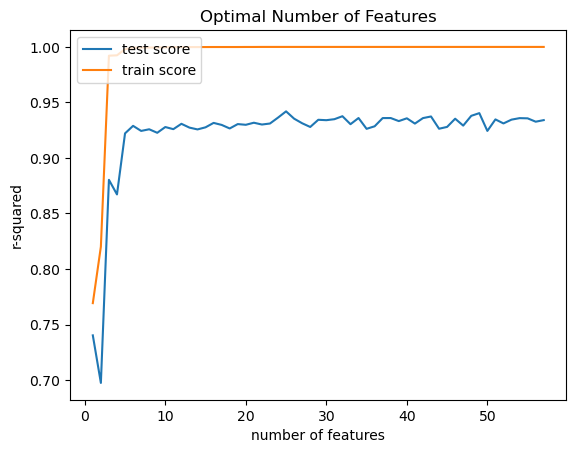

In [10]:
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [11]:
rfe = RFE(gbdt, n_features_to_select=25)             
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('K_frac', False, 25),
 ('Rb_frac', False, 21),
 ('Cs_frac', False, 26),
 ('MA_frac', False, 28),
 ('FA_frac', False, 27),
 ('Li_frac', False, 31),
 ('Ca_frac', False, 29),
 ('Sr_frac', False, 16),
 ('Ba_frac', False, 17),
 ('Ge_frac', False, 24),
 ('Sn_frac', False, 6),
 ('Pb_frac', False, 3),
 ('Be_frac', False, 30),
 ('Ni_frac', False, 32),
 ('Cl_frac', False, 22),
 ('Br_frac', False, 23),
 ('I_frac', False, 20),
 ('F_frac', False, 33),
 ('A_Ionic_radius', False, 19),
 ('B_Ionic_radius', False, 11),
 ('X_Ionic_radius', False, 2),
 ('A+B_Ionic_radius', True, 1),
 ('A+X_Ionic_radius', True, 1),
 ('B+X_Ionic_radius', True, 1),
 ('A/B_Ionic_radius', True, 1),
 ('A/X_Ionic_radius', True, 1),
 ('B/X_Ionic_radius', True, 1),
 ('Tolerance factor', True, 1),
 ('Octahedral factor', True, 1),
 ('A_Ionization energy(kJ/mol)', False, 13),
 ('B_Ionization energy(kJ/mol)', True, 1),
 ('X_Ionization energy(kJ/mol)', True, 1),
 ('A_Electron_affinity(kJ/mol)', True, 1),
 ('B_Electron_affinity(kJ/mol